# Draper Addition circuit with artificial random noise 

In [126]:
import numpy as np
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit import Gate

### QFT and IQFT

In [127]:
def qft(circuit):
    n = circuit.num_qubits
    for i in range(n):
        circuit.h(i)
        for j in range(i + 1, n):
            circuit.cp(np.pi / 2**(j - i), j, i)
        #circuit.barrier()
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)
    return circuit

def iqft(circuit):
    n = circuit.num_qubits
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)
    for i in range(n - 1, -1, -1):
        #circuit.barrier()
        for j in range(i - 1, -1, -1):
            circuit.cp(-np.pi / 2**(i - j), i, j)
        circuit.h(i)
    return circuit

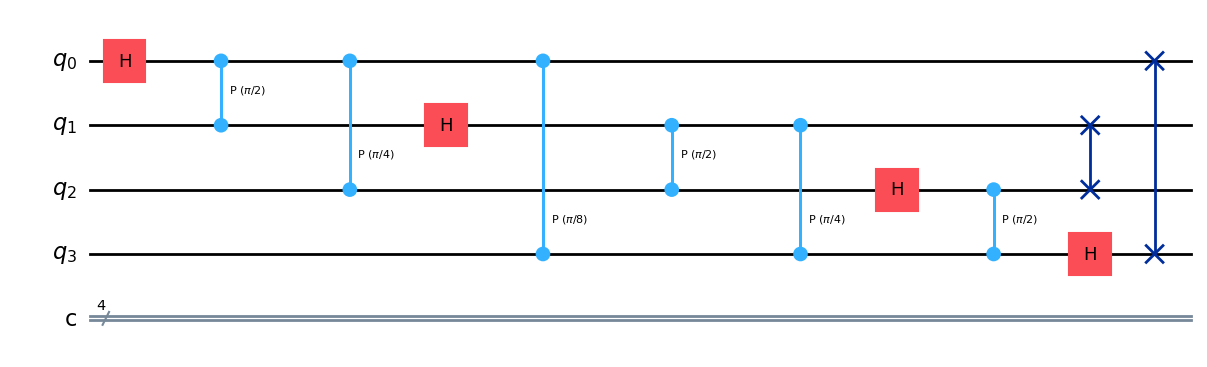

In [128]:
hello = qft(QuantumCircuit(4,4))
hello.draw('mpl')

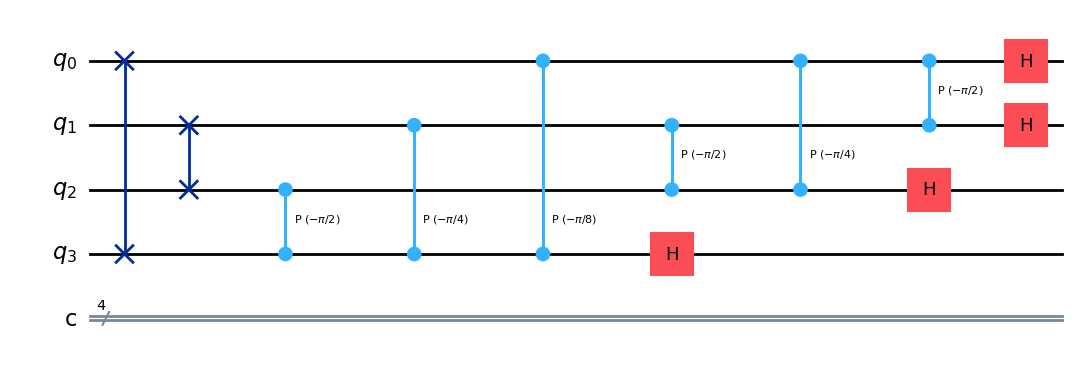

In [129]:
bye = iqft(QuantumCircuit(4,4))
bye.draw('mpl')

In [130]:
def quantum_sum(a, b):
    n = max(len(format(a, 'b')), len(format(a, 'b'))) + 1
    circuit = QuantumCircuit(2 * n, n)
    for i in range(n):
        if (a >> i) & 1:
            circuit.x(i)
        if (b >> i) & 1:
            circuit.x(i + n)
    circuit = qft(circuit)
    for i in range(n):
        circuit.cx(i + n, i)
    circuit = iqft(circuit)
    return circuit

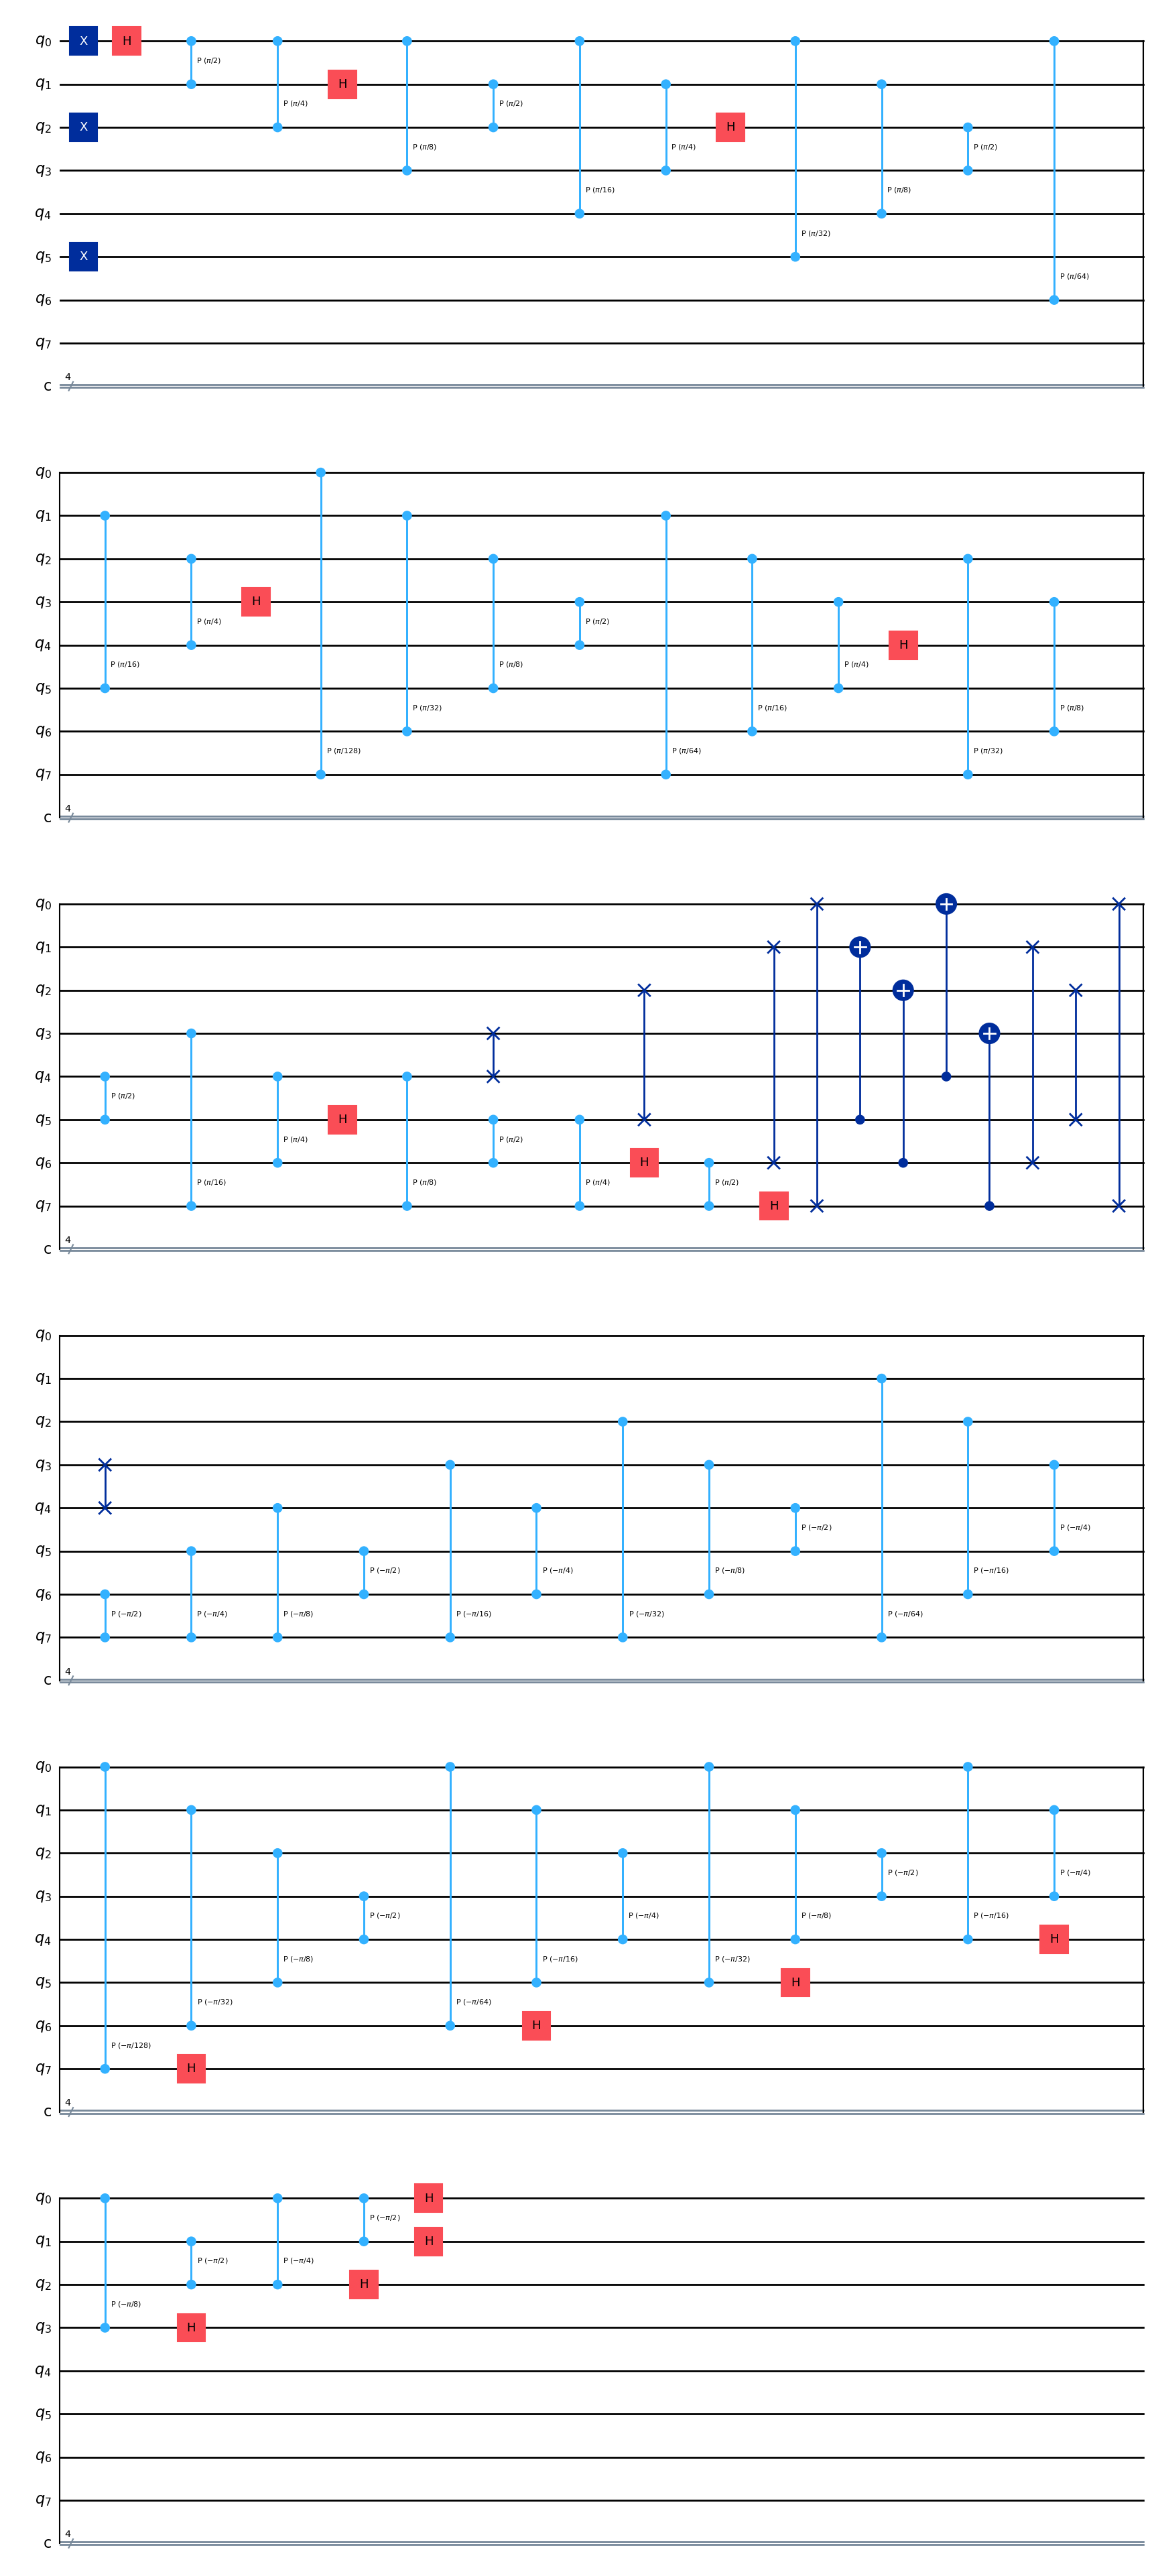

In [209]:
import qiskit.quantum_info as qi

qc = quantum_sum(5, 2)
qc.draw('mpl')

### Noise insertion using random pauli gates

In [210]:
# Pauli Gates as custom quantum operations
pauli_gates = {'X': Gate("x", 1, []), 'Y': Gate("y", 1, []), 'Z': Gate("z", 1, [])}

def add_noise(circuit, alpha, beta):
    noisy_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_qubits)
    for instr, qargs, _ in circuit:
        noisy_circuit.append(instr, qargs)
        noise_prob = alpha if instr.num_qubits == 1 else beta
        if np.random.rand() < noise_prob:
            noise_gate = pauli_gates[np.random.choice(['X', 'Y', 'Z'])]
            noisy_circuit.append(noise_gate, [qargs[0]])
    return noisy_circuit

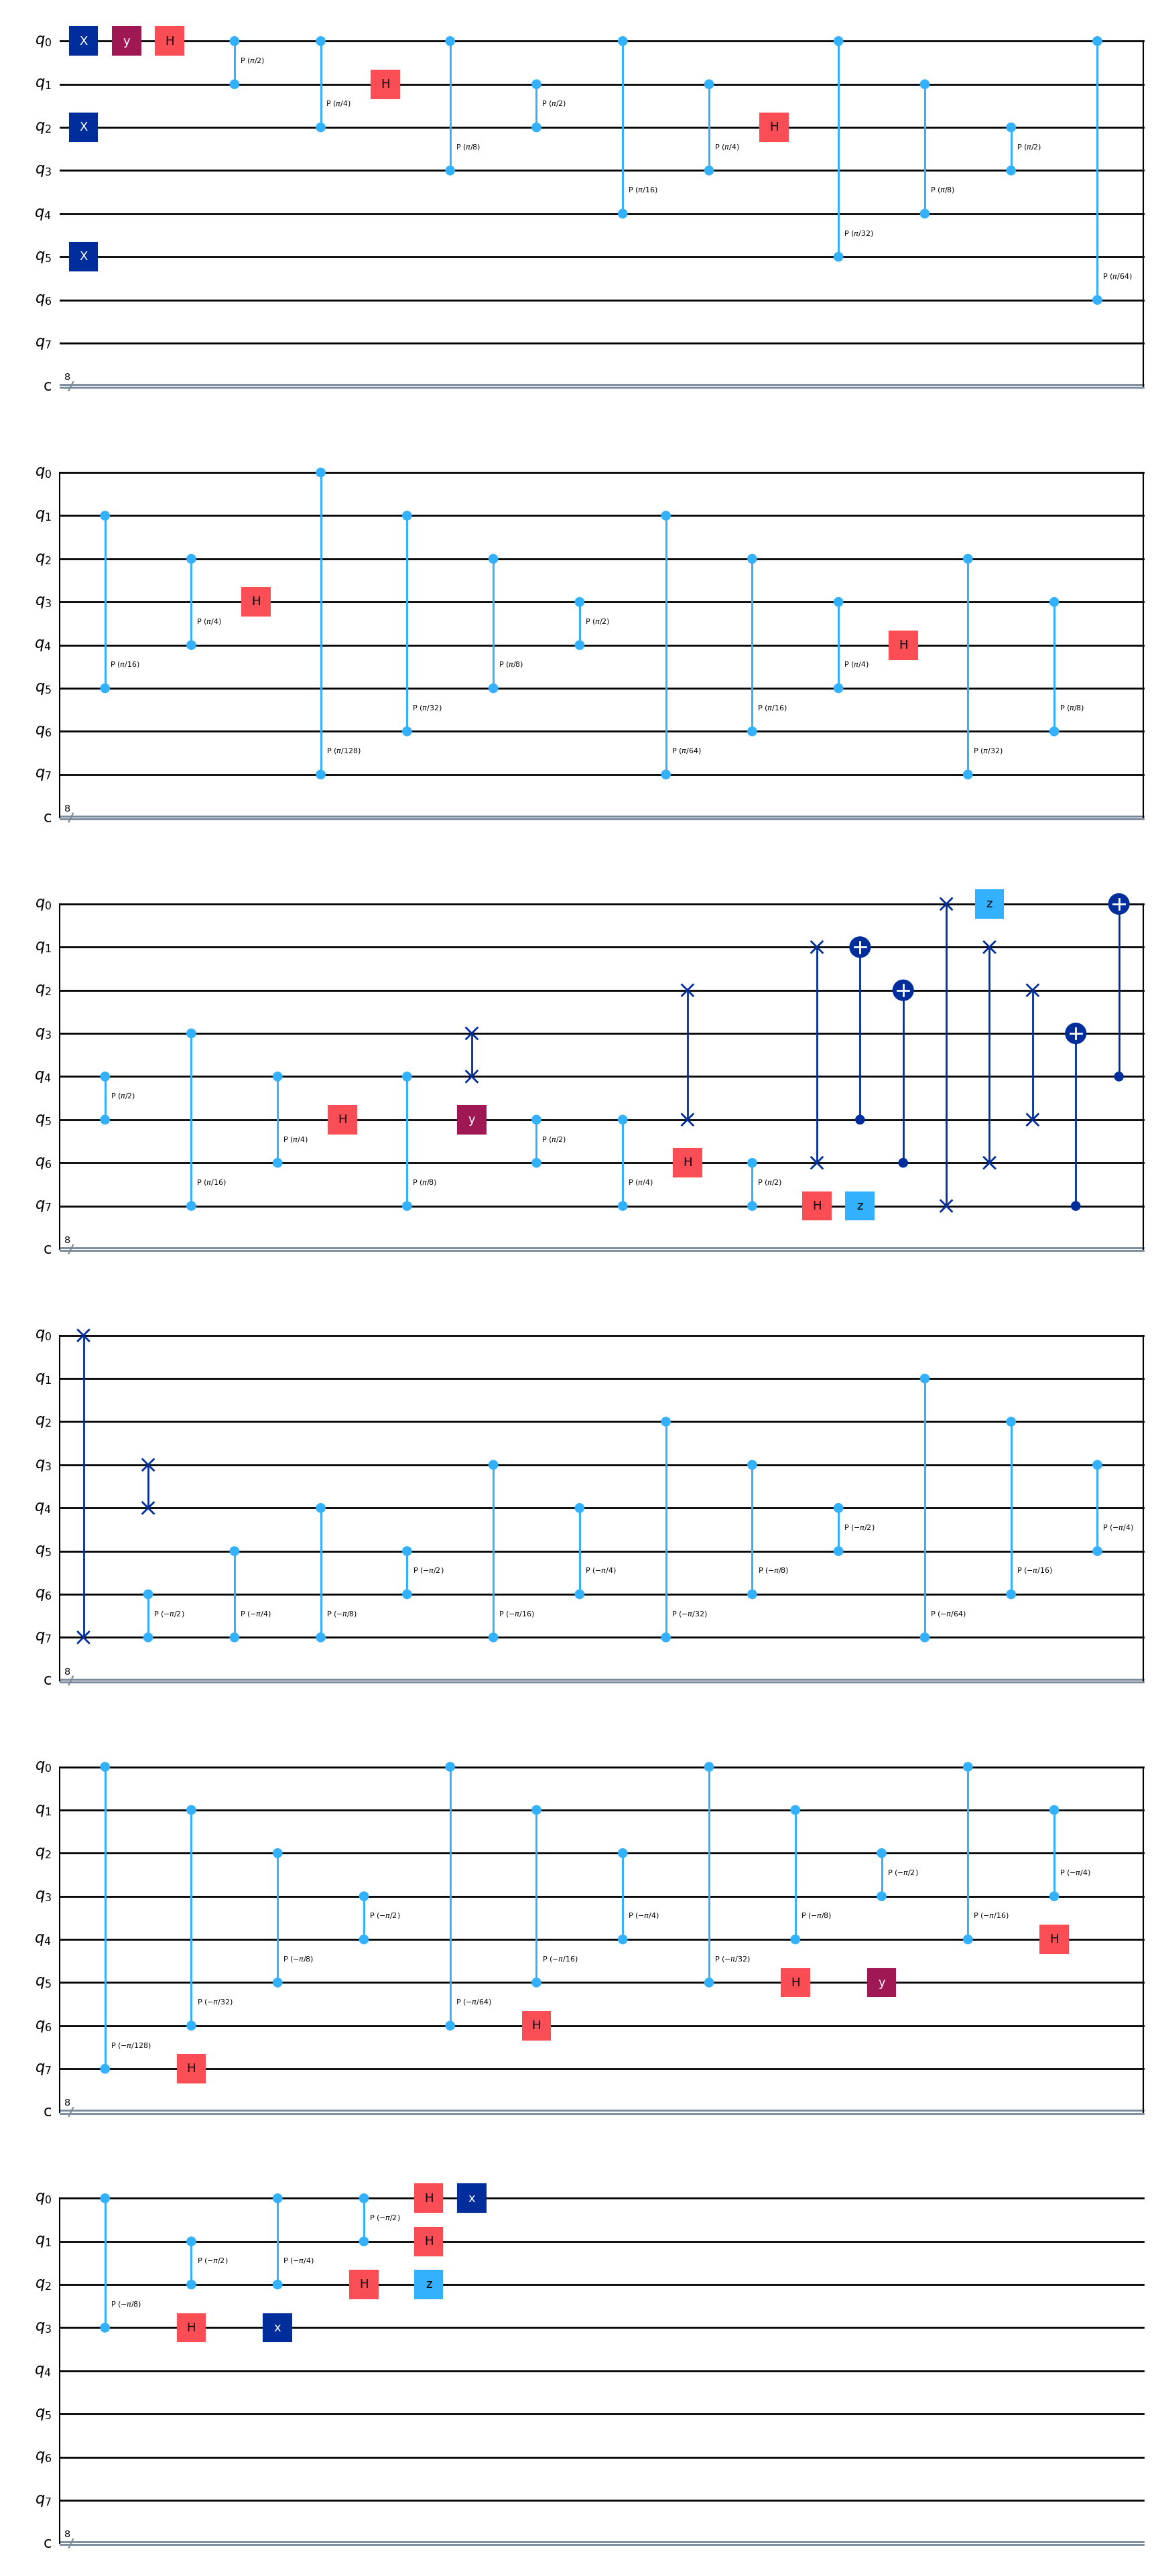

In [215]:
noisy_qc = add_noise(qc, alpha=0.2, beta=0.1)
noisy_qc.draw('mpl')

# Simulation

In [216]:
from qiskit_aer import AerSimulator, StatevectorSimulator, Aer

sim = AerSimulator()
basis = ['cx', 'id', 'rz', 'sx', 'x']

ideal = transpile(qc, sim, basis_gates=basis)
nonideal = transpile(noisy_qc, sim, basis_gates=basis)

ideal.measure_all()
nonideal.measure_all()

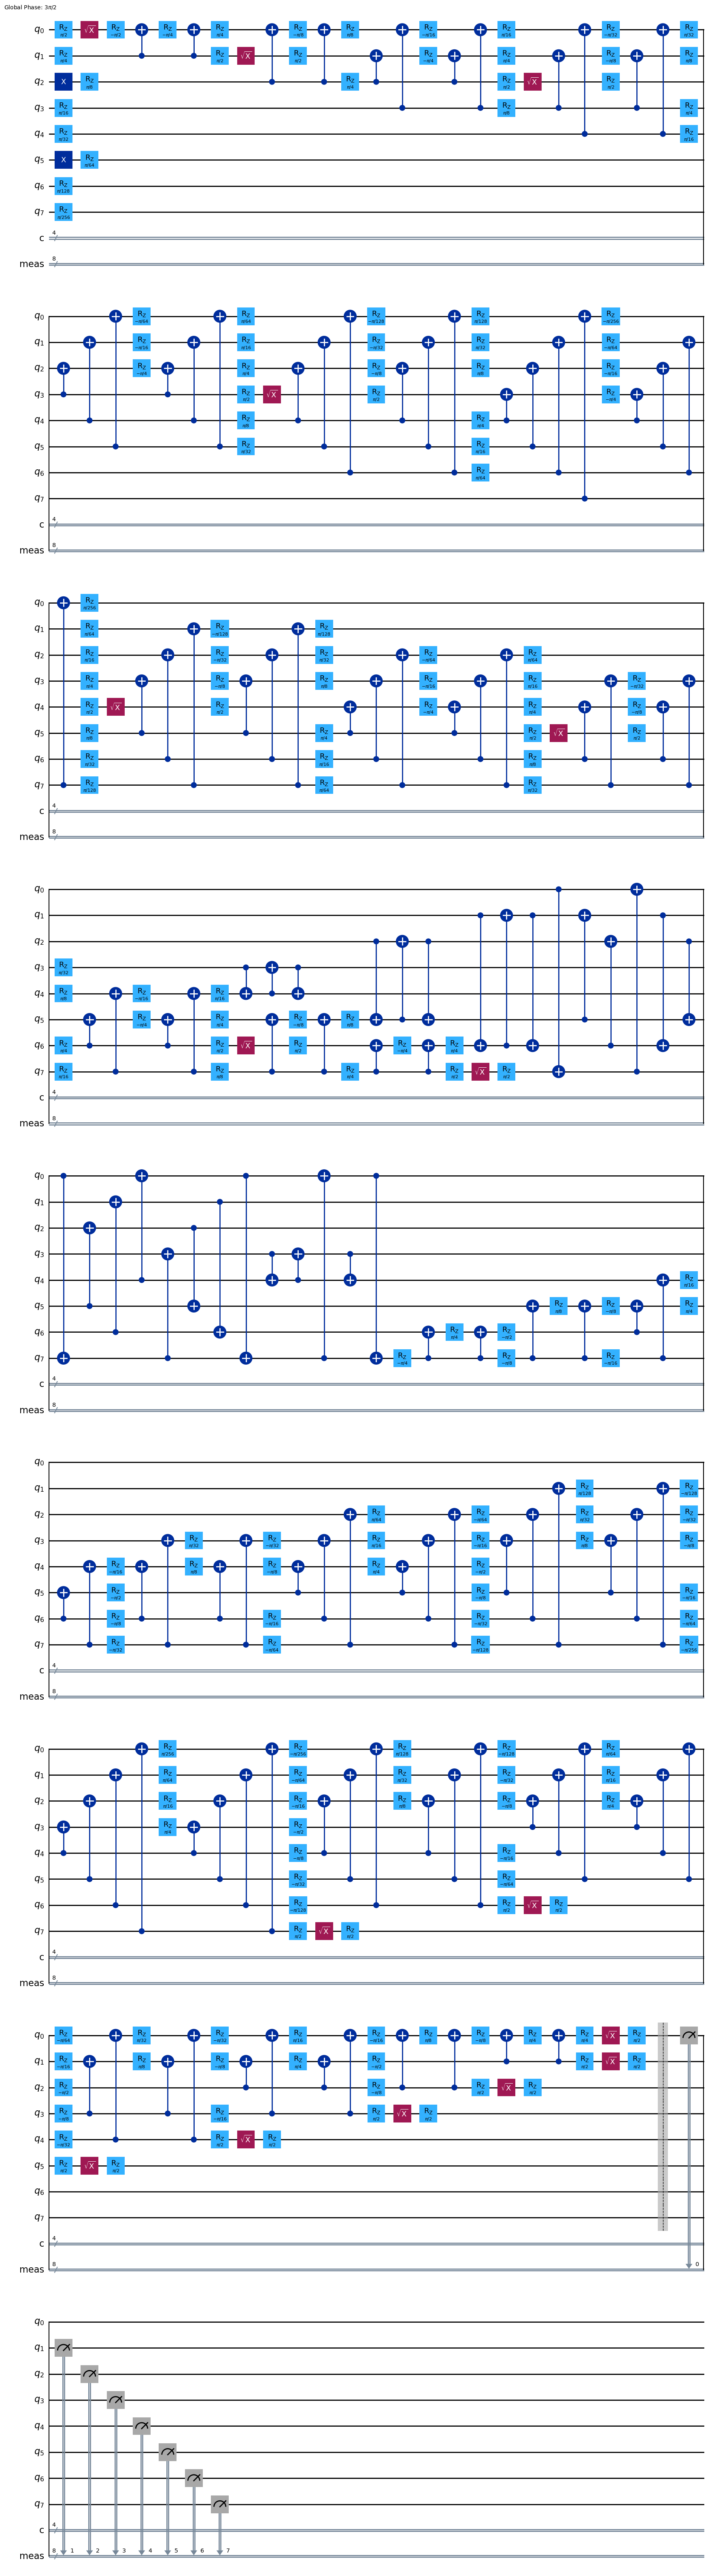

In [217]:
ideal.draw('mpl')

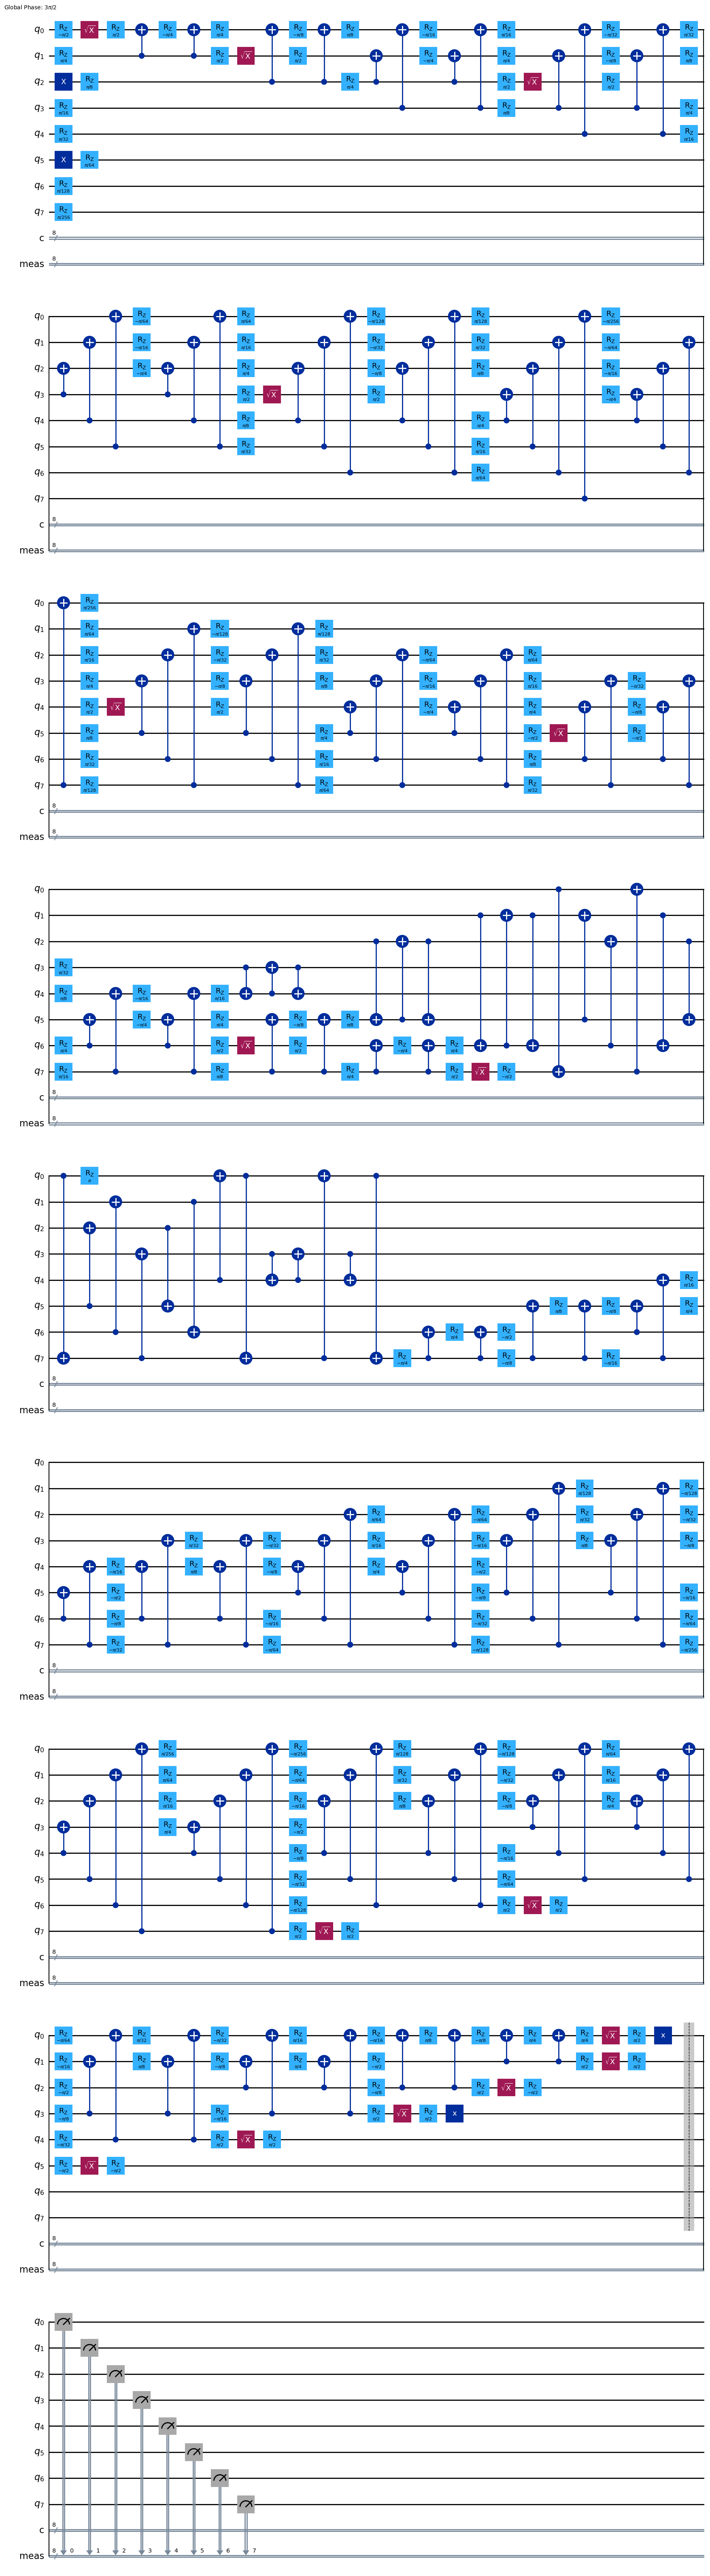

In [218]:
nonideal.draw('mpl')

In [233]:
from qiskit.providers.basic_provider import BasicSimulator

simulator = BasicSimulator()
result = simulator.run(ideal).result()
counts_ideal = result.get_counts()

simulator = Aer.get_backend('statevector_simulator')
result = simulator.run(ideal).result()
sv_ideal = result.get_statevector(ideal)
#sv_ideal

In [234]:
print(f"statevector is of {int(np.log2(np.asarray(sv_ideal).shape[0]))} qubits")

statevector is of 8 qubits


In [235]:
len(list(counts_ideal.keys())[0])

13

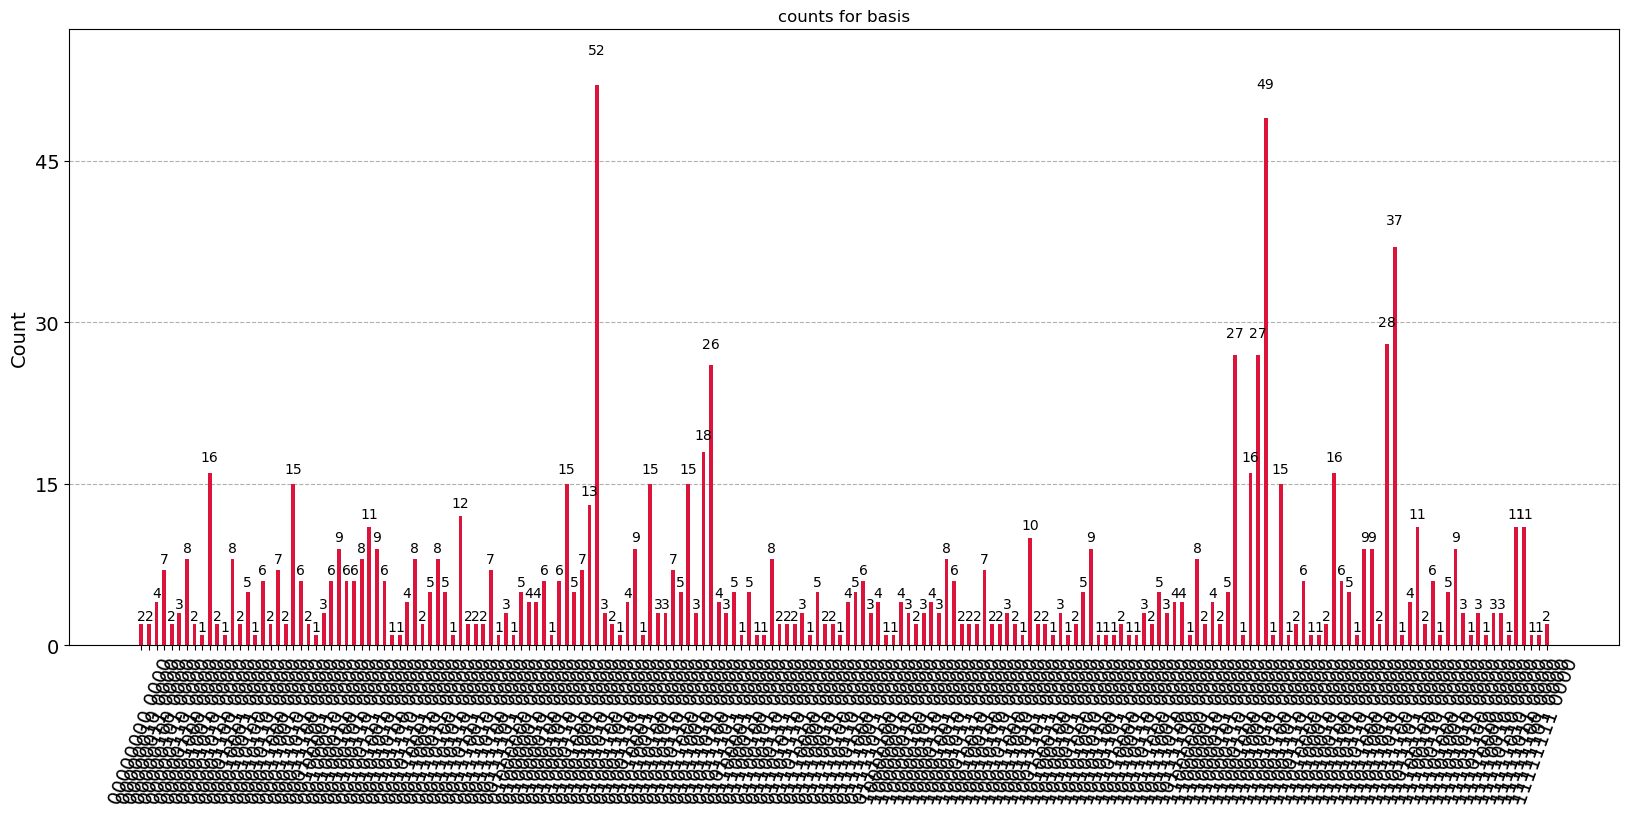

In [237]:
from qiskit.visualization import plot_histogram

plot_histogram(counts_ideal, figsize=(20,8), color='crimson', title= "counts for basis")

In [238]:
from qiskit.providers.basic_provider import BasicSimulator

simulator = BasicSimulator()
result = simulator.run(nonideal).result()
counts_nonideal = result.get_counts()

simulator = Aer.get_backend('statevector_simulator')
result = simulator.run(ideal).result()
sv_nonideal = result.get_statevector(ideal)
#sv_nonideal

In [240]:
print(f"statevector is of {int(np.log2(np.asarray(sv_nonideal).shape[0]))} qubits")

statevector is of 8 qubits


In [241]:
len(list(counts_nonideal.keys())[0])

17

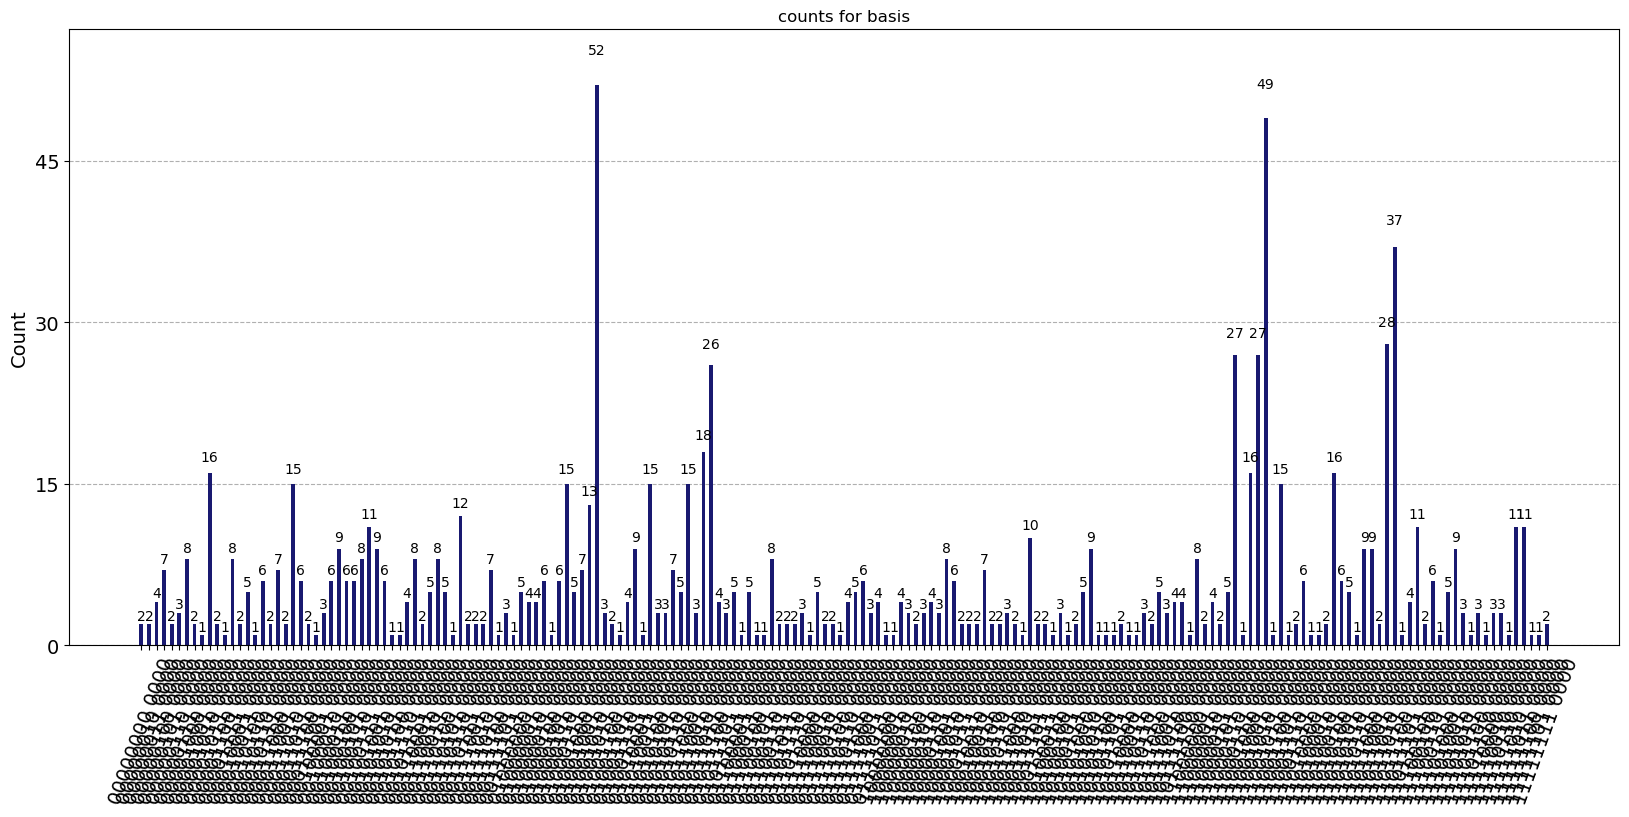

In [242]:
plot_histogram(counts_ideal, figsize=(20,8), color='midnightblue', title= "counts for basis")